# ARG Functions

This file contains some general ARG functions that may be useful for various applications. For now I'm keeping it separate from the algorithm documents, but eventually we will want to combine.

In [113]:
import msprime
import tskit
import numpy as np
import math
import random
from collections import defaultdict
from itertools import chain
import networkx as nx
import matplotlib.pyplot as plt
import graphviz

def plot_arg(ts):
    """
    Plot ARG using GraphViz. Slightly expands on code from Anastasia Ignatieva 
    (https://github.com/tskit-dev/tutorials/issues/43).
    """
    
    dot = graphviz.Digraph(strict=False)
    nodes = []

    # Internal nodes
    itr = iter(range(ts.num_samples, ts.num_nodes))
    for i in itr:
        if ts.node(i).flags == msprime.NODE_IS_RE_EVENT:
            # Only add one of the recombination nodes and make the other one invisible
            with dot.subgraph() as s:
                s.attr(rank = 'same')
                s.node(str(i), **{'shape': 'rectangle'}, label = str(i) + "/" + str(i+1))
                nodes.append(i)
                next(itr, None)
        else:
            dot.node(str(i), **{'shape': 'circle'})
            nodes.append(i)

    # Add sample nodes
    with dot.subgraph() as s:
        s.attr(rank = 'same')
        for n in ts.samples(): 
            s.node(str(n), **{'shape': 'doublecircle'})

    nodes = sorted(nodes)
    remove_nodes = []

    # Add edges
    check = [0,0]
    for e in ts.edges():
        ch = e.child
        pa = e.parent

        # Preventing duplicate edges
        if check == [pa, ch]:
            continue
        check = [pa, ch]

        # Check which edge to draw if there is a recombination
        if e.parent >= 1 and ts.node(pa).time == ts.node(pa-1).time and ts.node(pa).flags == ts.node(pa-1).flags == msprime.NODE_IS_RE_EVENT:
            ch = pa = -1
        elif e.child >= 1 and ts.node(ch).time == ts.node(ch-1).time and ts.node(ch).flags == ts.node(ch-1).flags == msprime.NODE_IS_RE_EVENT:
            ch -= 1

        if(ch >= 0 and pa >= 0):
            if ch >= 4 and pa == nodes[nodes.index(ch)+1]:
                remove_nodes.append(ch)

            if ts.first().interval.left >= e.left and ts.first().interval.right <= e.right and False:
                color = 'red'
                dot.edge(str(pa), str(ch), **{'arrowhead': 'none', 'color':color})
            else:
                color = 'black'
                dot.edge(str(pa), str(ch), **{'arrowhead': 'none', 'color':color})

    needed_connections = [x for x in nodes if x not in remove_nodes]
    for node in needed_connections[:-1]:
        dot.edge(str(nodes[nodes.index(node)+1]), str(node), weight='0', **{'style':'invis', 'arrowhead': 'none'})
    display(dot)

def convert_to_nx(ts, connect_recombination_nodes=False, recomb_nodes=[]):
    topology = defaultdict(list)
    for tree in ts.trees():
        for k, v in chain(tree.parent_dict.items()):
            if connect_recombination_nodes:
                if v in recomb_nodes and recomb_nodes.index(v)%2 == 1:
                    v -= 1
                if k in recomb_nodes and recomb_nodes.index(k)%2 == 1:
                    k -= 1
                if v not in topology[k]:
                    topology[k].append(v)
            else:
                if v not in topology[k]:
                    topology[k].append(v)
    nx_graph = nx.DiGraph(topology)
    return nx_graph

def check_for_missing_loop(node, loop):
    if node in loop and node == min(loop):
        return False
    else:
        return True

def locate_loops(ts):
    """
    Finds loops within the ARG. I thought that it would be easiest to utilize functions from
    networkx package. Identifies recombination events, converts the tree sequence into a networkx
    graph. The paired recombination nodes are merged together in this graph. Converts graph to 
    undirected, then calculates cycle basis. This does not identify 'bubbles', so we need to add
    an extra step to this.
    """
    
    edges = ts.tables.edges
    parent_list = list(edges.parent)
    child_list = list(edges.child)
    recomb_nodes = list(np.where(ts.tables.nodes.flags == 131072)[0])
    g = convert_to_nx(ts=ts, connect_recombination_nodes=True, recomb_nodes=recomb_nodes)
    loop_list = nx.cycle_basis(g.to_undirected())
    for node in recomb_nodes[::2]:
        true_false = []
        for loop in loop_list:
            true_false.append(check_for_missing_loop(node=node, loop=loop))
            #print(node, loop, check_for_missing_loop(node=node, loop=loop))
        if all(true_false):
            loop_list.append([node, parent_list[child_list.index(node)]])
    return loop_list

## Outlining the algorithm

I thought that it would be easiest to utilize functions from networkx package, so much of this algorithm revolves around that aspect. First,  we identify all of the recombination events. When building the networkx graph from the tree sequence, we merge the paired recombination nodes into a single node in the graph. Next, we converts graph to undirected and then calculate its cycle basis. From my understanding of math, this appears to be the set of loops that we are interested in (correct me if I am wrong). One obvious overloook is that by collapsing the paired recombination nodes together, we lose 'bubble'-style loops, so we need to add an extra step that checks that every recombination node has an associated loop, meaning that each recombination node is the minimum value node in a loop.

Seed: 2239


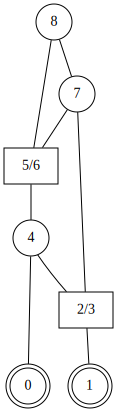

2 Loops Found: [[2, 7, 5, 4], [8, 7, 5]]


In [119]:
rs = random.randint(0,10000)

ts = msprime.sim_ancestry(
    samples=1,
    recombination_rate=1e-8,
    sequence_length=2000,
    population_size=10_000,
    record_full_arg=True,
    random_seed=rs
)

print("Seed:", rs)
plot_arg(ts)
loops = locate_loops(ts=ts)
print(len(loops), "Loops Found:", loops)

The algorithm does not appear to work for the below example. It would be good to discuss what loops we need to handle within this ARG, as it is more complicated than what we have previously worked through.

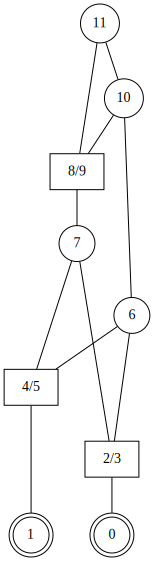

4 Loops Found: [[6, 10, 8, 7, 2], [11, 10, 8], [6, 4, 7, 2], [4, 7]]


In [120]:
ts = msprime.sim_ancestry(
    samples=1,
    recombination_rate=1e-8,
    sequence_length=2000,
    population_size=10_000,
    record_full_arg=True,
    random_seed=3824
)
plot_arg(ts)
loops = locate_loops(ts=ts)
print(len(loops), "Loops Found:", loops)

Doing this by hand, I would instead expect there to be three loops:

- 2,7,8,10,6
- 4,7,8,10,6
- 8,11,10

This implies that the cycle basis of the graph, may not be the correct solution to this problem.